In [1]:
import pandas as pd
import numpy as np
from taigapy import create_taiga_client_v3
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from statsmodels.stats.multitest import fdrcorrection
import colorcet as cc

## Reading data


TFs CRISPR effect

In [2]:
tfs_effect = pd.read_pickle("pydata/tfs_dependencies.pkl")

In [3]:
tfs_effect.shape

(1373, 1543)

Model information

In [4]:
model = pd.read_pickle("pydata/model_data.pkl")

In [5]:
model.head()

,ModelID,PatientID,CellLineName,StrippedCellLineName,DepmapModelType,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,OncotreeCode,PatientSubtypeFeatures,...,EngineeredModelDetails,CulturedResistanceDrug,PublicComments,CCLEName,HCMIID,ModelAvailableInDbgap,ModelSubtypeFeatures,WTSIMasterCellID,SangerModelID,COSMICID
0,ACH-000001,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,None,...,None,None,None,NIHOVCAR3_OVARY,None,Available in SRA,None,2201.0,SIDM00105,905933.0
1,ACH-000002,PT-5qa3uk,HL-60,HL60,AML,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,AML,"TP53(del), CDKN2A and NRAS mutations [PubMed=2...",...,None,None,None,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,None,Available in SRA,None,55.0,SIDM00829,905938.0
2,ACH-000003,PT-puKIyc,CACO2,CACO2,COAD,Bowel,Colorectal Adenocarcinoma,Colon Adenocarcinoma,COAD,None,...,None,None,None,CACO2_LARGE_INTESTINE,None,Available in SRA,None,NaN,SIDM00891,NaN
3,ACH-000004,PT-q4K2cp,HEL,HEL,AML,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,AML,"JAK2 and TP53 mutations,",...,None,None,None,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,None,Available in SRA,None,783.0,SIDM00594,907053.0
4,ACH-000005,PT-q4K2cp,HEL 92.1.7,HEL9217,AML,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,AML,JAK2 and TP53 mutations,...,None,None,None,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,None,Available in SRA,None,NaN,SIDM00593,NaN


In [6]:
model.shape

(2552, 47)

Expression data 

In [7]:
gene_expr= pd.read_pickle("pydata/tpmlog2p1.pkl")
gene_expr

,TFE3,MMADHC,PABPC1L,RELL2,GPT,GUSB,H4-16,DDB2,RPS4X,HINFP,...,OR2A42,HOXB7,NSA2,UGT2B11,ZNF747,NAA60,MYH4,MTAP,C14orf93,NR3C2
ACH-000873,3.506205,3.584484,4.572699,2.137186,0.525915,5.041027,1.179124,4.345084,10.069657,2.869262,...,0.032995,3.748717,5.155622,-0.009160,1.952132,4.141739,-0.000116,3.782797,2.193078,0.245980
ACH-000860,4.089100,6.886964,4.430887,2.528341,0.117545,5.589460,1.053103,4.127051,10.209273,4.024218,...,0.023290,-0.160952,6.753527,-0.009160,1.357422,4.268943,-0.000116,4.690644,3.372848,0.417233
ACH-000439,3.165189,5.836121,1.049685,3.957850,0.308481,6.517316,0.317849,4.238008,11.637030,4.678546,...,-0.016486,-0.189162,6.883302,2.206492,3.058301,4.573945,-0.000116,4.000853,2.199302,0.052468
ACH-000318,3.603682,5.844594,4.082083,2.102328,0.390166,5.082609,2.210189,4.881627,9.159418,2.489161,...,-0.016486,2.922211,5.594495,-0.009160,2.271837,3.791668,-0.000116,0.273937,3.222723,0.321795
ACH-001142,5.995286,7.071005,3.995839,2.349655,-0.056134,4.511908,2.253969,3.913061,10.173268,3.719160,...,0.042608,3.458342,7.431706,-0.009160,2.232625,4.852927,-0.000116,4.257783,2.358115,0.570824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-003180,5.165957,7.735123,1.888620,1.447676,0.305600,6.416978,0.369623,4.781201,9.478081,2.966378,...,0.097491,4.816006,6.277112,0.002097,2.609723,5.097519,0.023647,4.856428,2.661060,-0.016156
ACH-001979,4.985783,7.665280,3.026326,3.032295,0.305600,6.804347,0.735648,5.629513,11.373898,2.688530,...,0.018964,4.843341,7.279101,0.002097,2.272606,5.139305,-0.000713,4.964760,2.754223,0.492046
ACH-003274,3.463985,6.899029,2.126371,3.764047,0.340686,5.714290,0.450048,3.300497,10.796507,3.748022,...,0.018964,0.191719,6.945938,0.002097,2.520798,5.038073,0.011527,4.214451,3.669716,0.051750
ACH-002748,4.142447,6.848186,1.440711,3.091984,2.097855,7.121441,1.067238,2.825501,9.164170,3.436956,...,0.018964,2.835515,5.897340,0.002097,1.828925,5.208657,-0.000713,2.871649,2.019966,2.086770


In [8]:
gene_expr.columns

Index(['TFE3', 'MMADHC', 'PABPC1L', 'RELL2', 'GPT', 'GUSB', 'H4-16', 'DDB2',
       'RPS4X', 'HINFP',
       ...
       'OR2A42', 'HOXB7', 'NSA2', 'UGT2B11', 'ZNF747', 'NAA60', 'MYH4', 'MTAP',
       'C14orf93', 'NR3C2'],
      dtype='object', length=19139)

Filtering by E3 ligases

In [9]:
E3_ligases = pd.read_excel("data/E3_ligase_list.xlsx", skiprows=1)

In [10]:
E3_ligases

,Symbol,HGNC,uniprot_ids,Confidence Score,Ge.et.al,UbiHub,UbiBrowser
0,AHCTF1,HGNC:24618,Q8WYP5,1,Yes,No,No
1,ODAD2,HGNC:25583,Q5T2S8,1,Yes,No,No
2,BAZ1A,HGNC:960,Q9NRL2,1,Yes,No,No
3,BAZ1B,HGNC:961,Q9UIG0,1,Yes,No,No
4,BPTF,HGNC:3581,Q12830,1,Yes,No,No
...,...,...,...,...,...,...,...
1070,PTPA,HGNC:9308,Q15257,1,No,No,Yes
1071,RSAD2,HGNC:30908,Q8WXG1,1,No,No,Yes
1072,TNFAIP3,HGNC:11896,P21580,1,No,No,Yes
1073,TOM1,HGNC:11982,O60784,1,No,No,Yes


Keeping E3 ligases with confidence score >= 3

In [11]:
E3_ligases= E3_ligases[E3_ligases["Confidence Score"]>= 3]

In [12]:
E3_ligases

,Symbol,HGNC,uniprot_ids,Confidence Score,Ge.et.al,UbiHub,UbiBrowser
22,KDM2A,HGNC:13606,Q9Y2K7,3,Yes,Yes,Yes
46,RNF145,HGNC:20853,Q96MT1,3,Yes,Yes,Yes
49,RNF157,HGNC:29402,Q96PX1,3,Yes,Yes,No
50,RNF165,HGNC:31696,Q6ZSG1,3,Yes,Yes,No
52,RNF212,HGNC:27729,Q495C1,3,Yes,Yes,No
...,...,...,...,...,...,...,...
906,FBXO21,HGNC:13592,O94952,3,No,Yes,Yes
908,FBXO34,HGNC:20201,Q9NWN3,3,No,Yes,Yes
913,FBXW12,HGNC:20729,Q6X9E4,3,No,Yes,Yes
930,SPSB3,HGNC:30629,Q6PJ21,3,No,Yes,Yes


In [13]:
E3_list = E3_ligases[["Symbol"]]

In [14]:
E3_found = [E3 for E3 in E3_ligases["Symbol"] if E3 in gene_expr.columns]

In [15]:
len(E3_found)

490

In [16]:
E3_expr = gene_expr[E3_found]
#E3_expr.set_index(E3_expr.columns[0], inplace=True)
E3_expr.index.name = "ModelID"
E3_expr.to_csv("pydata/E3_expr.csv")

In [17]:
E3_expr.shape

(2150, 490)

In [18]:
E3_expr_filtered = E3_expr[E3_expr.index.isin(tfs_effect.index)]


In [19]:
tfs_effect = tfs_effect[tfs_effect.index.isin(E3_expr_filtered.index)]

In [20]:
E3_expr_filtered

,KDM2A,RNF145,RNF157,RNF165,RNF212,RNF39,SH3RF2,TRAF4,TRIM52,TRIM69,...,TRIM58,RNF183,DET1,FBXL18,FBXL22,FBXO21,FBXO34,FBXW12,SPSB3,NEURL1
ModelID,,,,,,,,,,,,,,,,,,,,,
ACH-000873,4.805632,5.543729,3.002984,1.240481,2.804849,1.179537,0.368279,4.908319,2.940464,2.130041,...,0.023357,0.136215,0.811795,1.821145,0.392631,3.293790,3.996343,0.031072,4.439057,2.033055
ACH-000860,5.109451,6.228351,3.154089,-0.050736,6.138382,0.960508,3.412382,6.686536,3.495564,2.552602,...,-0.003895,0.202619,1.473609,2.156250,0.469268,4.704779,4.255051,0.008786,3.099573,-0.027190
ACH-000318,5.178853,5.600976,1.072733,1.859878,3.989043,1.211360,3.377755,4.967826,2.820978,3.232389,...,0.036783,0.041863,2.175636,1.703410,0.644177,3.536461,4.225302,-0.013942,3.170298,-0.039473
ACH-000544,4.222034,4.372058,0.577673,0.318982,1.484165,0.321551,2.419065,3.913216,1.073388,2.844980,...,-0.003895,0.041863,0.770171,1.582698,0.035165,2.230736,2.202646,-0.002522,2.265232,0.195830
ACH-000695,4.732436,6.187262,6.202246,3.792376,0.045527,0.717659,-0.055574,4.728454,3.048940,5.010681,...,0.009799,2.530908,1.672480,2.271262,1.384436,5.219347,3.966362,0.232942,4.805218,3.381491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-003369,4.945874,6.384171,2.604001,0.045018,0.028522,5.117251,3.101456,6.506408,2.333899,3.158871,...,0.002095,0.540489,1.956966,2.375530,0.324243,3.825577,4.448722,0.014191,4.132686,0.057915
ACH-001843,4.577282,5.525016,3.198651,0.074187,0.028522,0.302531,3.161468,5.374923,3.154989,2.795809,...,0.002095,0.222363,2.003115,2.289807,0.106592,3.484118,3.186593,0.054262,4.760854,0.040802
ACH-001164,4.380155,4.920597,3.772658,0.158382,3.595464,0.315404,0.177162,5.593718,2.779292,2.644664,...,0.031943,-0.012212,2.350303,2.122116,0.815943,3.990739,2.648104,0.112919,4.245529,2.414012


In [21]:
E3_expr_filtered = E3_expr_filtered.sort_index()

In [22]:
E3_expr_filtered.to_csv("pydata/E3_expr_filtered.csv")

In [23]:
tfs_effect = tfs_effect.sort_index()

In [24]:
tfs_effect

,TFAP2A,TFAP2B,TFAP2C,TFAP2D,TFAP2E,ARID3A,ARID3B,ARID3C,ARID5A,ARID5B,...,THAP6,THAP7,THAP8,THAP9,BMAL1,BMAL2,ZNF875,CBLL2,ZUP1,TBXT
ACH-000001,0.032275,-0.052657,-0.099978,-0.040024,0.060890,0.102625,-0.121782,0.027268,-0.243864,-0.096952,...,-0.087478,-0.317241,-0.052855,-0.065466,-0.645930,0.140806,-0.892911,0.215270,-0.014496,0.169385
ACH-000004,0.145169,0.066916,-0.074218,-0.125423,0.240744,-0.105335,-0.734358,-0.027738,-0.136107,0.008301,...,-0.462663,-0.194145,0.130992,-0.251477,-0.205806,-0.090015,0.168027,0.280951,-0.182743,0.082328
ACH-000005,0.171513,-0.361703,-0.017947,-0.103094,0.315080,0.069369,-0.026263,-0.022071,0.006219,0.200501,...,-0.094047,-0.180209,-0.163869,-0.026951,-0.207084,-0.134599,0.374316,-0.018200,-0.283811,0.058674
ACH-000007,-0.073170,0.200249,-0.292673,-0.238197,-0.059635,0.041934,-0.329979,-0.080568,-0.067746,-0.198359,...,-0.071877,-0.105574,0.144103,-0.023396,0.140064,-0.069550,0.180594,0.104287,-0.311871,-0.006005
ACH-000009,0.224490,-0.001485,-0.172446,0.018604,0.034670,-0.316335,-0.053869,0.059077,-0.058235,-0.495861,...,-0.059427,-0.024232,-0.025614,-0.115766,-0.111904,0.027901,0.098494,0.060150,0.014514,0.136429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-003578,-0.070363,-0.033106,-0.243238,-0.370448,-0.108596,0.023995,-0.181551,-0.213355,-0.284968,-0.052868,...,0.040754,-0.215718,0.054442,-0.043687,-0.052162,-0.106350,0.018423,0.079413,0.005381,0.105370
ACH-003580,-0.081792,-0.181257,-0.381345,-0.202155,0.109083,-0.004828,0.018773,-0.112690,-0.071700,-0.386106,...,-0.040535,-0.178553,0.195923,0.063442,-0.119621,-0.077457,-0.205756,-0.021425,0.016575,0.077086
ACH-003587,-0.128495,-0.347200,-0.229025,-0.420290,0.106401,-0.087998,0.062317,-0.158840,0.009397,-0.086930,...,0.022615,0.289244,0.065706,0.043732,-0.095881,0.210714,-0.104913,-0.141233,0.058059,0.013758
ACH-003590,0.029615,-0.090314,-0.087541,-0.343993,0.073768,-0.087375,-0.049801,-0.047360,0.009253,-0.328680,...,0.038728,-0.037614,0.067970,0.051580,-0.043185,-0.007903,-0.250206,-0.080775,0.102683,0.069626


In [25]:
def clean_dataframe(df):
    threshold = len(df)* 0.5
    ## Drop columns with more than 50% NaN values
    df_cleaned = df.dropna(thresh=threshold, axis=1)
    ## Fill remaining NaN values with 0
    df_cleaned.fillna(0.0, inplace = True)
    return df_cleaned

In [26]:
tfs_effect_filtered = clean_dataframe(tfs_effect)

/var/folders/_5/qbyf0kk5779gpj3nnpqbc7wr0000gn/T/ipykernel_2108/4020608179.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.fillna(0.0, inplace = True)


In [27]:
tfs_effect_filtered.shape

(1303, 1530)

Saving final dependency matrix

In [28]:
tfs_effect_filtered.to_pickle("pydata/tfs_dependencies_filtered.pkl")

In [29]:
E3_expr_filtered = clean_dataframe(E3_expr_filtered)

In [31]:
E3_expr_filtered.to_pickle("pydata/e3_expression_filtered.pkl")

In [30]:
E3_expr_filtered.shape

(1303, 490)

In [32]:
combined_df = pd.concat([E3_expr_filtered, tfs_effect_filtered], axis=1)

In [33]:
combined_df

,KDM2A,RNF145,RNF157,RNF165,RNF212,RNF39,SH3RF2,TRAF4,TRIM52,TRIM69,...,THAP6,THAP7,THAP8,THAP9,BMAL1,BMAL2,ZNF875,CBLL2,ZUP1,TBXT
ACH-000001,5.350041,5.781840,0.546522,0.705279,1.197362,1.059804,2.521187,7.234615,3.183593,3.869171,...,-0.087478,-0.317241,-0.052855,-0.065466,-0.645930,0.140806,-0.892911,0.215270,-0.014496,0.169385
ACH-000004,4.284098,5.500041,0.153294,-0.050736,0.006805,1.603985,-0.118006,5.283476,2.520298,3.332695,...,-0.462663,-0.194145,0.130992,-0.251477,-0.205806,-0.090015,0.168027,0.280951,-0.182743,0.082328
ACH-000005,4.778394,5.916353,0.153294,-0.036715,-0.033062,0.759238,-0.031406,5.271112,2.280233,3.506815,...,-0.094047,-0.180209,-0.163869,-0.026951,-0.207084,-0.134599,0.374316,-0.018200,-0.283811,0.058674
ACH-000007,4.224493,5.444087,0.973254,0.453291,0.155439,0.502655,4.343146,5.804416,3.777697,2.995643,...,-0.071877,-0.105574,0.144103,-0.023396,0.140064,-0.069550,0.180594,0.104287,-0.311871,-0.006005
ACH-000009,5.983751,4.399241,3.985872,-0.009083,-0.006353,0.177682,5.073699,6.078089,2.672089,1.827145,...,-0.059427,-0.024232,-0.025614,-0.115766,-0.111904,0.027901,0.098494,0.060150,0.014514,0.136429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-003578,4.968736,6.247850,3.229085,1.252558,0.028522,0.302531,1.243030,5.249282,1.927991,3.833978,...,0.040754,-0.215718,0.054442,-0.043687,-0.052162,-0.106350,0.018423,0.079413,0.005381,0.105370
ACH-003580,3.701024,4.573275,5.132026,2.788532,0.028522,0.302531,0.145815,5.441013,0.823754,2.292339,...,-0.040535,-0.178553,0.195923,0.063442,-0.119621,-0.077457,-0.205756,-0.021425,0.016575,0.077086
ACH-003587,4.601888,5.682004,3.519492,0.171958,0.028522,0.449147,2.889733,3.853863,2.846582,3.332735,...,0.022615,0.289244,0.065706,0.043732,-0.095881,0.210714,-0.104913,-0.141233,0.058059,0.013758
ACH-003590,5.082909,5.123834,0.015165,1.935926,0.028522,0.302531,0.145815,4.751390,2.666914,3.472305,...,0.038728,-0.037614,0.067970,0.051580,-0.043185,-0.007903,-0.250206,-0.080775,0.102683,0.069626


## Getting correlations

Getting correlation matrix using corr

In [34]:
correlation_matrix = combined_df.corr(method='pearson')

In [35]:
correlation_matrix_sub = correlation_matrix.iloc[490:, 0:490]
correlation_matrix_sub

,KDM2A,RNF145,RNF157,RNF165,RNF212,RNF39,SH3RF2,TRAF4,TRIM52,TRIM69,...,TRIM58,RNF183,DET1,FBXL18,FBXL22,FBXO21,FBXO34,FBXW12,SPSB3,NEURL1
TFAP2A,0.089017,-0.024139,-0.034831,0.086152,0.046387,0.006934,0.107532,-0.098612,0.118285,0.057958,...,-0.031684,0.025547,-0.014733,0.007648,0.007450,0.031771,0.067514,0.042828,0.018869,0.022869
TFAP2B,0.032968,-0.008062,-0.113241,-0.128609,-0.033364,0.070427,0.121289,0.030358,-0.007928,-0.053624,...,-0.012807,0.013880,-0.119031,-0.015300,-0.008199,-0.104813,0.062846,-0.040334,-0.005152,-0.111271
TFAP2C,-0.032333,0.109756,-0.003691,0.001688,-0.009955,-0.014231,0.087528,-0.125858,0.030673,0.101357,...,0.001081,0.035386,0.009428,-0.050119,-0.110322,-0.007863,0.031842,-0.040416,-0.077564,-0.022441
TFAP2D,0.028609,0.001658,-0.054254,-0.070333,-0.038743,0.066332,0.000316,-0.028062,0.001374,0.046943,...,-0.008799,0.036974,-0.027961,-0.003285,-0.069139,-0.086448,-0.007751,-0.039763,0.006115,-0.067851
TFAP2E,-0.092472,0.006399,0.007139,-0.025501,-0.020489,0.016495,-0.028078,-0.039797,-0.026081,0.018728,...,0.025432,-0.069657,-0.018823,-0.031458,-0.060629,-0.050157,-0.000110,-0.017990,-0.084697,-0.077285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BMAL2,-0.039433,-0.026492,0.046743,0.017470,-0.071786,-0.029153,-0.026050,0.035556,-0.007787,-0.037764,...,0.037701,-0.016240,0.008665,-0.022015,-0.032587,-0.016537,0.003392,0.041527,-0.001378,0.015863
ZNF875,-0.014202,-0.038015,0.035823,-0.020896,-0.016128,-0.004373,0.001426,-0.000546,0.001625,-0.054421,...,-0.023077,-0.011556,0.027848,-0.038287,-0.040887,-0.070664,-0.061496,-0.076384,-0.016382,-0.014208
CBLL2,-0.025652,-0.007402,-0.008519,-0.023749,-0.025607,0.038122,0.047826,0.056537,-0.055155,-0.043087,...,0.033451,0.017487,-0.080436,-0.049913,0.005128,-0.042078,-0.013143,-0.017794,-0.032196,-0.018919
ZUP1,0.027411,-0.033594,0.020139,-0.020553,-0.010675,-0.008731,-0.014691,0.015151,0.013522,-0.022071,...,-0.022510,0.029002,-0.020241,-0.011832,-0.015242,0.012270,0.003249,-0.036258,0.020579,-0.021115


/Users/dianae/Tools/miniforge3/envs/cpboot/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/dianae/Tools/miniforge3/envs/cpboot/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


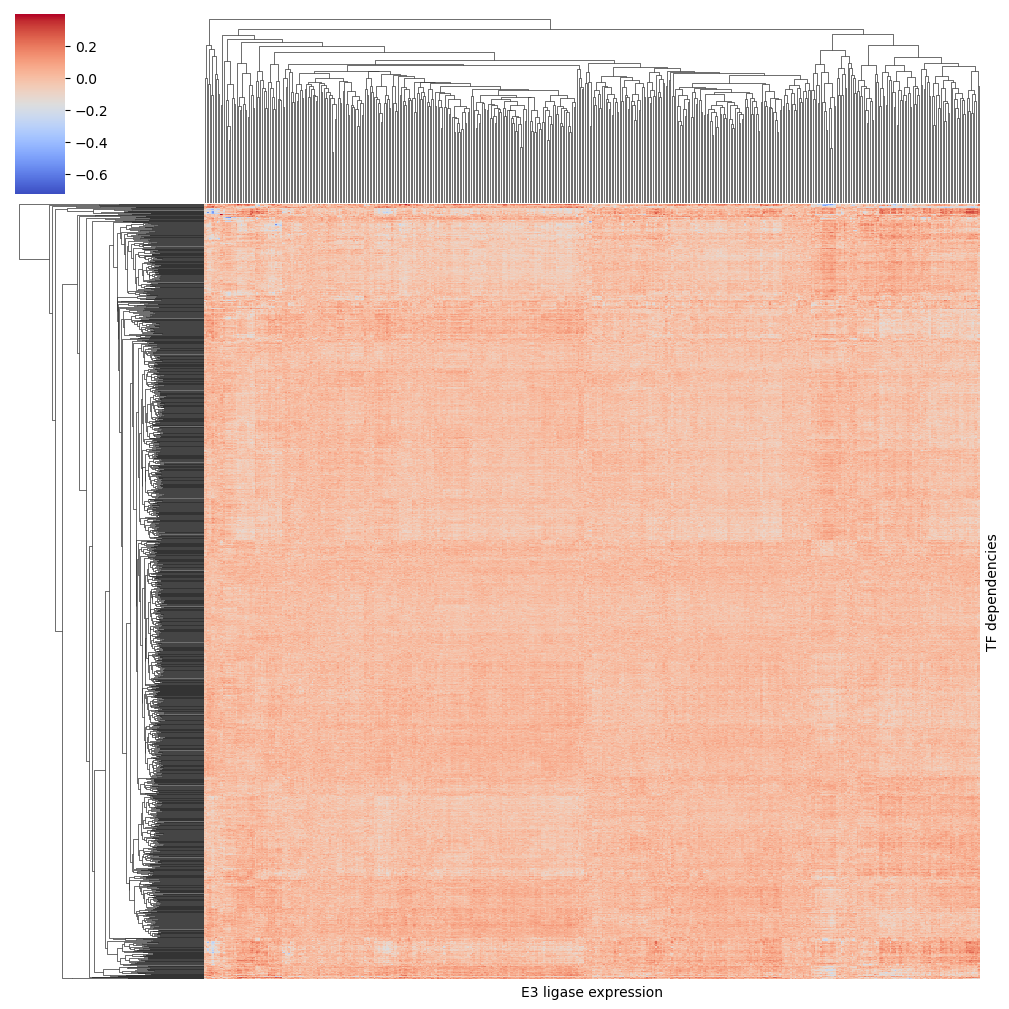

In [36]:
g=sns.clustermap(correlation_matrix_sub, 
            xticklabels = False, 
            yticklabels = False, 
            cmap='coolwarm')

g.ax_heatmap.set_xlabel('E3 ligase expression')
g.ax_heatmap.set_ylabel('TF dependencies')
plt.show()


Getting correlation matrix using `pearsonr`

In [37]:
pvals = []
corrs = []
tfs = []
e3s = []
for e3_col in E3_expr_filtered.columns:
    for tf_col in tfs_effect_filtered.columns:
        # Compute Pearson correlation and p-value
        corr, p_value = pearsonr(E3_expr_filtered[e3_col], tfs_effect_filtered[tf_col])
        # Append results to the DataFrame
        pvals.append(p_value)
        corrs.append(corr)
        tfs.append(tf_col)
        e3s.append(e3_col)

correlation_df = pd.DataFrame({
    "TF" : tfs,
    "E3_ligase" : e3s,
    "p-val": pvals,
    "corr": corrs
})

In [38]:
correlation_df

,TF,E3_ligase,p-val,corr
0,TFAP2A,KDM2A,0.001297,0.089017
1,TFAP2B,KDM2A,0.234345,0.032968
2,TFAP2C,KDM2A,0.243494,-0.032333
3,TFAP2D,KDM2A,0.302117,0.028609
4,TFAP2E,KDM2A,0.000832,-0.092472
...,...,...,...,...
749695,BMAL2,NEURL1,0.567250,0.015863
749696,ZNF875,NEURL1,0.608380,-0.014208
749697,CBLL2,NEURL1,0.495043,-0.018919
749698,ZUP1,NEURL1,0.446343,-0.021115


In [39]:
correlation_df = correlation_df.sort_values(by = "corr")

In [40]:
correlation_df.head(n=15)

,TF,E3_ligase,p-val,corr
398849,SOX10,TRIM51,1.647227e-213,-0.725675
408029,SOX10,TRIM63,1.407835e-173,-0.674384
407051,MITF,TRIM63,5.011464e-126,-0.595795
135807,ISL1,MARCHF11,1.256724e-107,-0.558241
41093,MYB,KLHL6,3.202731e-104,-0.550724
80506,EBF1,DTX1,5.623424e-104,-0.550177
633506,MYOD1,KLHL40,1.284372e-100,-0.542559
397871,MITF,TRIM51,4.171134e-98,-0.536732
62249,SOX10,BIRC7,7.317064e-91,-0.519256
40726,EBF1,KLHL6,1.252864e-89,-0.516176


In [41]:
correlation_df.to_pickle("pydata/tf_dependency_e3ls_expr_correlation.pkl")

In [42]:
correlation_df['q-value'] = fdrcorrection(correlation_df['p-val'].values)[1]

In [43]:
correlation_df.head()

,TF,E3_ligase,p-val,corr,q-value
398849,SOX10,TRIM51,1.647227e-213,-0.725675,1.234926e-207
408029,SOX10,TRIM63,1.407835e-173,-0.674384,5.277271e-168
407051,MITF,TRIM63,5.011464e-126,-0.595795,1.252365e-120
135807,ISL1,MARCHF11,1.256724e-107,-0.558241,2.355415e-102
41093,MYB,KLHL6,3.202731e-104,-0.550724,4.802175e-99


In [44]:
correlation_df["qlog10"] = np.log10(correlation_df["q-value"]) * -1


In [45]:
correlation_df.head()

,TF,E3_ligase,p-val,corr,q-value,qlog10
398849,SOX10,TRIM51,1.647227e-213,-0.725675,1.234926e-207,206.908359
408029,SOX10,TRIM63,1.407835e-173,-0.674384,5.277271e-168,167.277591
407051,MITF,TRIM63,5.011464e-126,-0.595795,1.252365e-120,119.902269
135807,ISL1,MARCHF11,1.256724e-107,-0.558241,2.355415e-102,101.627933
41093,MYB,KLHL6,3.202731e-104,-0.550724,4.802175e-99,98.318562


In [46]:
correlation_df["name"] = correlation_df["TF"] + "-" + correlation_df["E3_ligase"]

In [47]:
correlation_df.head()

,TF,E3_ligase,p-val,corr,q-value,qlog10,name
398849,SOX10,TRIM51,1.647227e-213,-0.725675,1.234926e-207,206.908359,SOX10-TRIM51
408029,SOX10,TRIM63,1.407835e-173,-0.674384,5.277271e-168,167.277591,SOX10-TRIM63
407051,MITF,TRIM63,5.011464e-126,-0.595795,1.252365e-120,119.902269,MITF-TRIM63
135807,ISL1,MARCHF11,1.256724e-107,-0.558241,2.355415e-102,101.627933,ISL1-MARCHF11
41093,MYB,KLHL6,3.202731e-104,-0.550724,4.802175e-99,98.318562,MYB-KLHL6


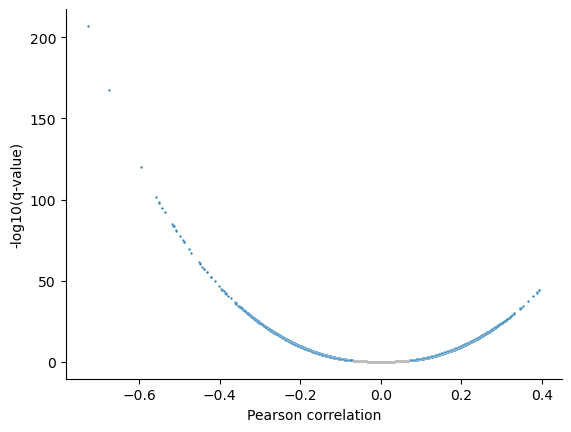

In [51]:
ax = plt.subplot(111)
sns.scatterplot(data = correlation_df[correlation_df["q-value"] >= 0.1], x = "corr", y = "qlog10",
                s = 1, color = "grey")
sns.scatterplot(data = correlation_df[(correlation_df["q-value"] < 0.1)], x = "corr", y = "qlog10",
                s = 3)
plt.xlabel("Pearson correlation")
plt.ylabel("-log10(q-value)")
ax.spines[['right', 'top']].set_visible(False)



In [ ]:
correlation_df

### Plotting lowest corr

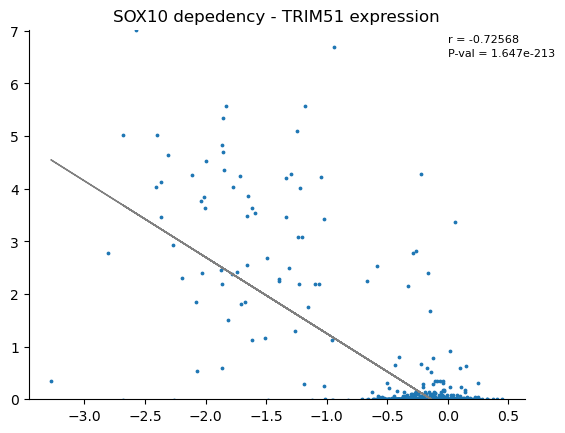

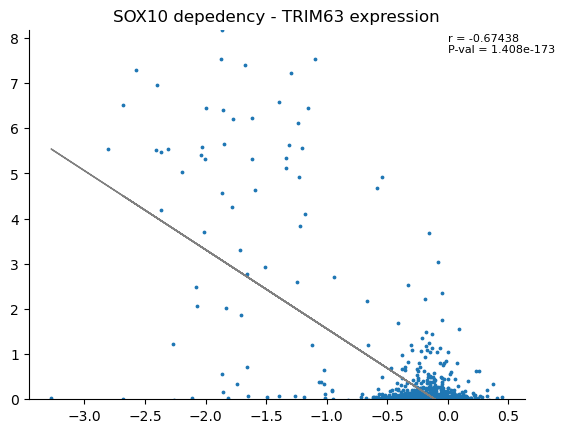

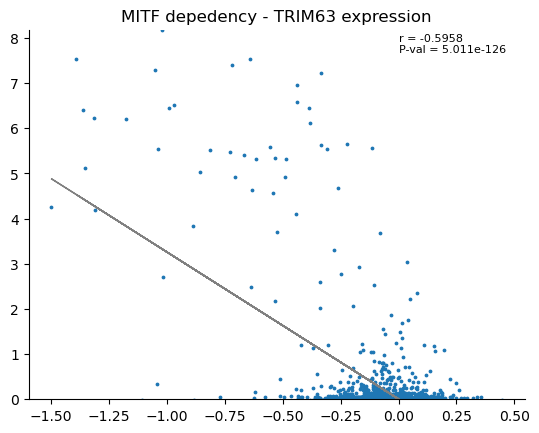

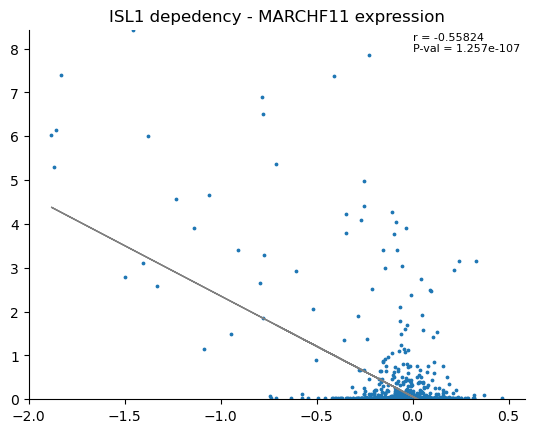

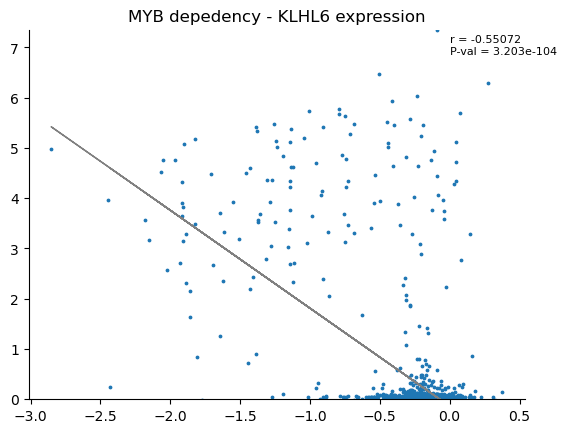

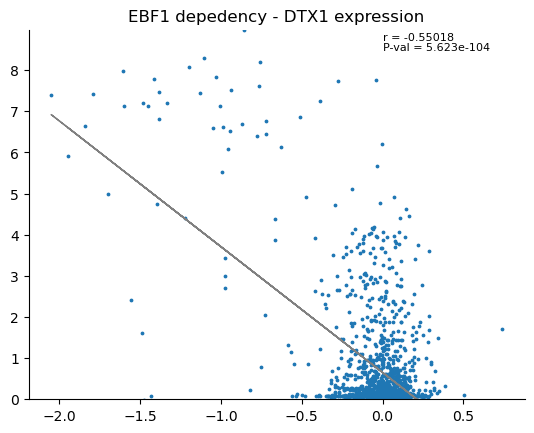

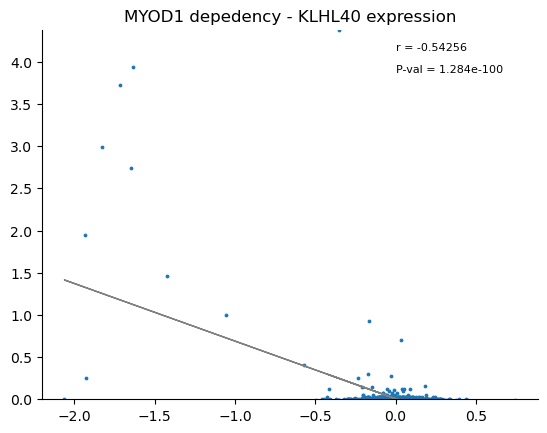

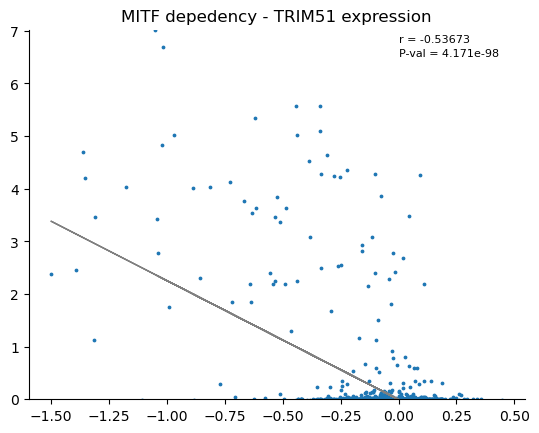

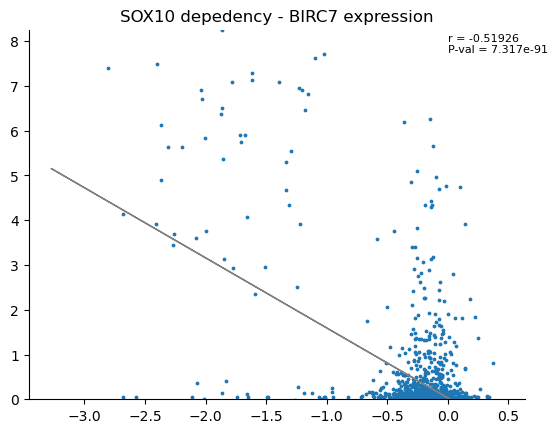

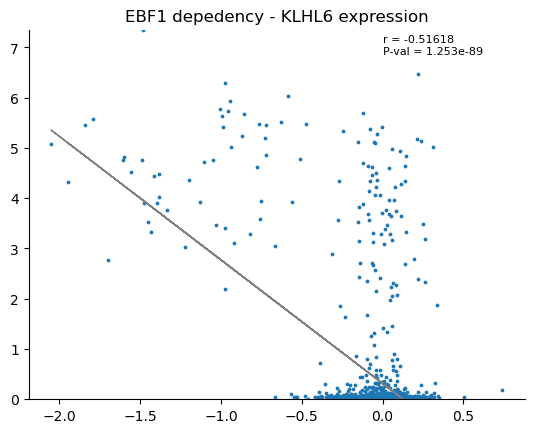

In [116]:
for i in range(10):
    tf = correlation_df.iloc[i]["TF"]
    e3_ligase = correlation_df.iloc[i]["E3_ligase"]
    x = crispr_dependencies_3_filtered[tf]
    y = E3_expr_filtered[e3_ligase]
    m, b = np.polyfit(x, y, 1)
    ax = plt.subplot(111)
    ax.scatter(x, E3_expr_filtered[e3_ligase], s=3)
    plt.ylim(0, max(E3_expr_filtered[e3_ligase]))
    ax.text(0, max(y)-0.25, f"r = {round(correlation_df.iloc[i]["corr"], 5)}", fontsize = 8)
    ax.text(0, max(y)-0.5, f"P-val = {correlation_df.iloc[i]["p-val"]:.3e}", fontsize = 8)
    ax.plot(x, m*x + b, color='grey', linewidth=1)
    ax.spines[['right', 'top']].set_visible(False)
    plt.title(f"{tf} depedency - {e3_ligase} expression")
    plt.show()